<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.04/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Installs latest version of TensorFlow 2.X 
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.5 kB/s 
     |████████████████████████████████| 438 kB 45.5 MB/s 
     |████████████████████████████████| 5.8 MB 37.1 MB/s 
     |████████████████████████████████| 1.6 MB 39.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [2]:
# Import our dependencies
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import sklearn as skl
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf

In [3]:
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu 

In [4]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

# Read the CSV and Perform Data Cleaning for Machine Learning

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://aiscience22.s3.us-west-1.amazonaws.com/joined.csv"

spark.sparkContext.addFile(url)
joined_data_df = spark.read.csv(SparkFiles.get("joined.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
joined_data_df.show()

+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|extractedts|is_retweet|is_quote_status|weekofyear|        cleaned_text|   negative|    neutral|   positive|search_results|    weight|
+-------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+-----------+----------+---------------+----------+--------------------+-----------+-----------+-----------+--------------+----------+
|     Theo1001|      312|      123|      38156|   2008-05-14|    2022-04-22|          67|[{''text'': ''Sta...|      en|             0| 2022-04-22|      true|          false|        16|thank you si

In [6]:
# convert spark dataframe to pandas
joined_data_df = joined_data_df.toPandas()

joined_data_df.head(5)



,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,extractedts,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,2022-04-22,True,False,16,thank you sir we will not forget those who con...,0.010234,0.719316,0.270449,196000.0,0.000985
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",en,5,2022-04-24,False,True,16,of course pas de surprise tainted by her close...,0.004823,0.675433,0.319744,94500.0,0.000475
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,2022-04-24,True,False,16,no corridors from again russians did not allow...,0.018234,0.883309,0.098457,94500.0,0.000475
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",en,0,2022-04-24,True,False,16,thank you,0.169791,0.608387,0.221821,94500.0,0.000475
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",en,2,2022-04-22,False,False,16,president biden unveils m worth of military as...,0.156944,0.766128,0.076928,196000.0,0.000985


In [7]:
# convert text to text lenght
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()

joined_data_df.head()

,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,favorite_count,...,is_retweet,is_quote_status,weekofyear,cleaned_text,negative,neutral,positive,search_results,weight,text_length
0,Theo1001,312,123,38156,2008-05-14,2022-04-22,67,"[{''text'': ''StandWithUkraine'', ''indices'':...",en,0,...,True,False,16,thank you sir we will not forget those who con...,0.010234,0.719316,0.270449,196000.0,0.000985,80.0
1,ereguly,4787,9149,22818,2008-12-31,2022-04-24,3,"[{''text'': ''LePen'', ''indices'': [28, 34]},...",en,5,...,False,True,16,of course pas de surprise tainted by her close...,0.004823,0.675433,0.319744,94500.0,0.000475,70.0
2,davidgodfrey,5003,464,44931,2008-10-12,2022-04-24,97,"[{''text'': ''Mariupol'', ''indices'': [36, 45]}]",en,0,...,True,False,16,no corridors from again russians did not allow...,0.018234,0.883309,0.098457,94500.0,0.000475,123.0
3,cazacioc,1712,1019,38691,2008-12-06,2022-04-24,500,"[{''text'': ''SlavaUkraini'', ''indices'': [30...",en,0,...,True,False,16,thank you,0.169791,0.608387,0.221821,94500.0,0.000475,9.0
4,Daily_Express,761,935851,1066678,2008-12-05,2022-04-22,0,"[{''text'': ''Ukraine'', ''indices'': [63, 71]}]",en,2,...,False,False,16,president biden unveils m worth of military as...,0.156944,0.766128,0.076928,196000.0,0.000985,59.0


In [8]:
# When were the earliest and latest tweets in this dataset created
earliest_tweet = joined_data_df["tweetcreatedts"].min()
latest_tweet = joined_data_df["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-04-22, and the latest was at 2022-08-18


In [9]:
# Drop part of the columns with text values
preprocessed_data_df = joined_data_df
preprocessed_data_df.drop("cleaned_text", axis=1, inplace=True)
preprocessed_data_df.drop("username", axis=1, inplace=True)
preprocessed_data_df.drop("hashtags", axis=1, inplace=True)
preprocessed_data_df.drop("language", axis=1, inplace=True)
preprocessed_data_df.drop("extractedts", axis=1, inplace=True)
preprocessed_data_df.drop("weekofyear", axis=1, inplace=True)
preprocessed_data_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,favorite_count,is_retweet,is_quote_status,negative,neutral,positive,search_results,weight,text_length
0,312,123,38156,2008-05-14,2022-04-22,67,0,True,False,0.010234,0.719316,0.270449,196000.0,0.000985,80.0
1,4787,9149,22818,2008-12-31,2022-04-24,3,5,False,True,0.004823,0.675433,0.319744,94500.0,0.000475,70.0
2,5003,464,44931,2008-10-12,2022-04-24,97,0,True,False,0.018234,0.883309,0.098457,94500.0,0.000475,123.0
3,1712,1019,38691,2008-12-06,2022-04-24,500,0,True,False,0.169791,0.608387,0.221821,94500.0,0.000475,9.0
4,761,935851,1066678,2008-12-05,2022-04-22,0,2,False,False,0.156944,0.766128,0.076928,196000.0,0.000985,59.0


In [10]:
# Generate our categorical variable list
cat_var = preprocessed_data_df.dtypes[preprocessed_data_df.dtypes == "object"].index.tolist()
cat_var

['usercreatedts', 'tweetcreatedts']

In [11]:
# Check the number of unique values in each column
preprocessed_data_df[cat_var].nunique()

usercreatedts     5792
tweetcreatedts     118
dtype: int64

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(preprocessed_data_df[attrition_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(attrition_cat)
encode_df.head()

NameError: ignored

In [ ]:
# Merge one-hot encoded features and drop the originals
preprocessed_data_df = preprocessed_data_df.merge(encode_df,left_index=True, right_index=True)
preprocessed_data_df = preprocessed_data_df.drop(attrition_cat,1)
preprocessed_data_df.head()

In [13]:
# Drop part of the columns with boolean values
preprocessed_data_df.drop("is_retweet", axis=1, inplace=True)
preprocessed_data_df.drop("is_quote_status", axis=1, inplace=True)
preprocessed_data_df.head(5)

,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,favorite_count,negative,neutral,positive,search_results,weight,text_length
0,312,123,38156,2008-05-14,2022-04-22,67,0,0.010234,0.719316,0.270449,196000.0,0.000985,80.0
1,4787,9149,22818,2008-12-31,2022-04-24,3,5,0.004823,0.675433,0.319744,94500.0,0.000475,70.0
2,5003,464,44931,2008-10-12,2022-04-24,97,0,0.018234,0.883309,0.098457,94500.0,0.000475,123.0
3,1712,1019,38691,2008-12-06,2022-04-24,500,0,0.169791,0.608387,0.221821,94500.0,0.000475,9.0
4,761,935851,1066678,2008-12-05,2022-04-22,0,2,0.156944,0.766128,0.076928,196000.0,0.000985,59.0


In [14]:
# Drop the User Created Column as we don't need it anymore
preprocessed_data_df.drop("usercreatedts", axis=1, inplace=True)

# Drop the positive and neutral columns for now
preprocessed_data_df.drop("positive", axis=1, inplace=True)
preprocessed_data_df.drop("neutral", axis=1, inplace=True)
preprocessed_data_df.head(5)

,following,followers,totaltweets,tweetcreatedts,retweetcount,favorite_count,negative,search_results,weight,text_length
0,312,123,38156,2022-04-22,67,0,0.010234,196000.0,0.000985,80.0
1,4787,9149,22818,2022-04-24,3,5,0.004823,94500.0,0.000475,70.0
2,5003,464,44931,2022-04-24,97,0,0.018234,94500.0,0.000475,123.0
3,1712,1019,38691,2022-04-24,500,0,0.169791,94500.0,0.000475,9.0
4,761,935851,1066678,2022-04-22,0,2,0.156944,196000.0,0.000985,59.0


In [15]:
# get the shape of the new DataFrame
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

451700 rows and 10 columns


In [16]:
# Drop the null rows
joined_data_df = joined_data_df.dropna()
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

83147 rows and 10 columns


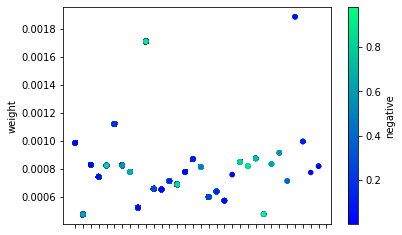

In [17]:
# Plotting the data
preprocessed_data_df.plot.scatter(x="tweetcreatedts", y="weight", c="negative", colormap="winter")

# Standartization Data


In [18]:
# Convert datetime to float
preprocessed_data_df["tweetcreatedts"] = pd.to_datetime(preprocessed_data_df["tweetcreatedts"])
preprocessed_data_df["tweetcreatedts"] = pd.to_numeric(preprocessed_data_df.index, downcast='float')

In [19]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [20]:
# Fit the StandardScaler
scaler.fit(preprocessed_data_df)

StandardScaler()

In [21]:
# Scale the data
scaled_data = scaler.transform(preprocessed_data_df)

In [22]:
# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, columns=preprocessed_data_df.columns)
transformed_scaled_data.head(5)

,following,followers,totaltweets,tweetcreatedts,retweetcount,favorite_count,negative,search_results,weight,text_length
0,-0.290730,-0.082565,-0.429799,-1.732047,-0.166776,-0.038498,-1.117600,-0.421136,-0.421136,-0.844024
1,0.050655,-0.063895,-0.520322,-1.732039,-0.210311,0.066278,-1.133604,-1.102583,-1.102584,-0.984011
2,0.067133,-0.081859,-0.389813,-1.732032,-0.146368,-0.038498,-1.093940,-1.102583,-1.102584,-0.242080
3,-0.183928,-0.080711,-0.426641,-1.732024,0.127772,-0.038498,-0.645686,-1.102583,-1.102584,-1.837931
4,-0.256477,1.852954,5.640446,-1.732016,-0.212352,0.003412,-0.683684,-0.421136,-0.421136,-1.137996


# Using Neural Networks Model

In [23]:
from sklearn.model_selection import train_test_split
# Split our preprocessed data into our features and target arrays
y = transformed_scaled_data["negative"].values
X = transformed_scaled_data.drop(["negative"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [24]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile the model
# tf.keras.losses.MeanAbsolutePercentageError(
#    reduction="auto", name="mean_absolute_percentage_error")
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
# Fit the model to the training data
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)
# fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
10587/10587 [==============================] - 29s 3ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/100
10587/10587 [==============================] - 21s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/100
10587/10587 [==============================] - 20s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/100
10587/10587 [==============================] - 19s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/100
10587/10587 [==============================] - 20s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/100
10587/10587 [==============================] - 21s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/100
10587/10587 [==============================] - 20s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/100
10587/10587 [==============================] - 19s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/100
10587/10587 [==============================] - 21s 2ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/100
10587/10587 [===========

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3529/3529 - 4s - loss: nan - accuracy: 0.0000e+00 - 4s/epoch - 1ms/step
Loss: nan, Accuracy: 0.0


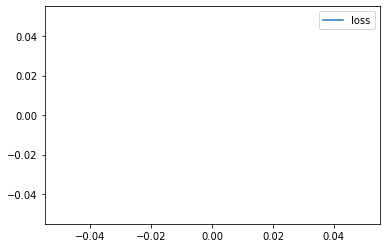

In [33]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

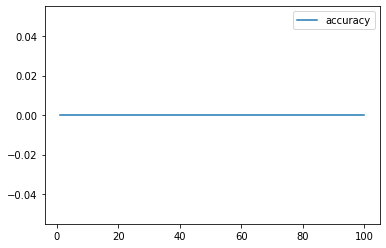

In [34]:
# Plot the accuracy
history_df.plot(y="accuracy")

The old code for regression

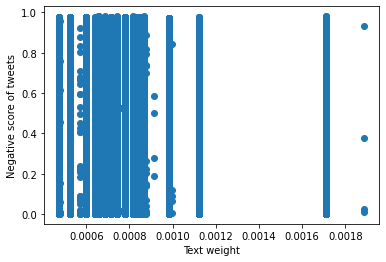

In [35]:
#Get the plot by weight of tweet
import matplotlib.pyplot as plt
plt.scatter(joined_data_df.weight, joined_data_df.negative)
plt.xlabel('Text weight')
plt.ylabel('Negative score of tweets')
plt.show()